<a href="https://colab.research.google.com/github/nataliepham6720/16-745_Optimal_Control/blob/main/LQR_QP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

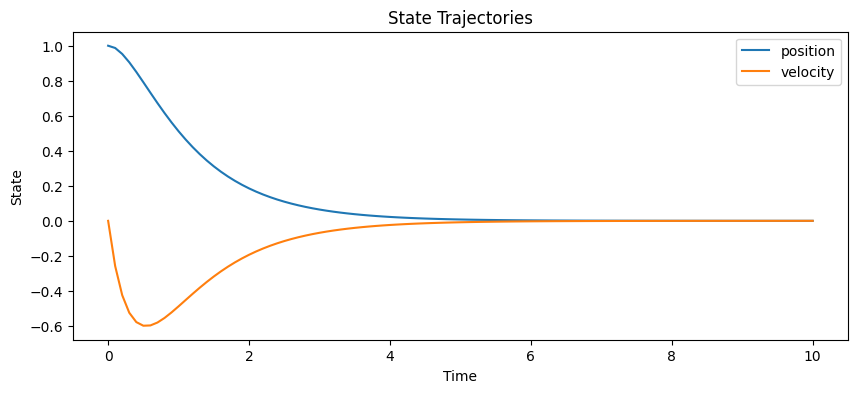

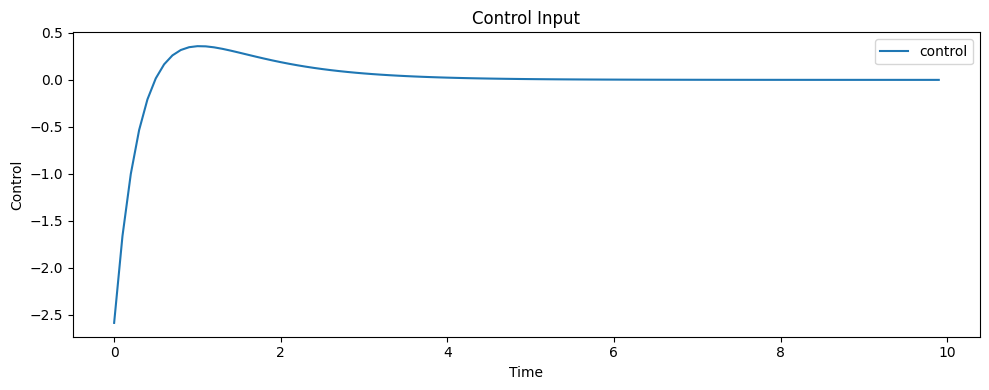

Total cost J = 6.6586122089613005


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import block_diag, eye, kron, csr_matrix
from scipy.linalg import solve

# Discrete dynamics
h = 0.1
A = np.array([[1, h],
              [0, 1]])
B = np.array([[0.5 * h ** 2],
              [h]])

n, m = 2, 1
Tfinal = 10.0
N = int(Tfinal / h) + 1
thist = np.linspace(0, h * (N - 1), N)

# Initial condition
x0 = np.array([1.0, 0.0])

# Cost matrices (sparse)
Q = 1.0 * eye(n, format='csr')
R = 0.1 * eye(m, format='csr')
Qn = 1.0 * eye(n, format='csr')

# Cost function
def J(xhist, uhist):
    cost = 0.5 * xhist[:, -1].T @ Qn @ xhist[:, -1]
    for k in range(N - 1):
        cost += 0.5 * xhist[:, k].T @ Q @ xhist[:, k]
        cost += 0.5 * uhist[k] * R.toarray() * uhist[k]
    return cost.item()

# Cost matrix H (sparse block-diagonal: [R, Q, R, Q, ..., Qn])
blocks = [R]
for _ in range(N - 2):
    blocks.append(block_diag([Q, R], format='csr'))
blocks.append(Qn)
H = block_diag(blocks, format='csr')

# Dynamics constraints matrix C
C = kron(eye(N - 1, format='csr'), np.hstack([B, -np.eye(n)]))
C = C.toarray()  # we modify it, so convert to dense
for k in range(1, N - 1):
    C[k * n:(k + 1) * n, (k - 1) * (n + m) + m:(k - 1) * (n + m) + m + n] = A

# Constraint RHS
d = np.zeros(n * (N - 1))
d[:n] = -A @ x0

# Solve KKT system
KKT = np.block([
    [H.toarray(), C.T],
    [C, np.zeros((C.shape[0], C.shape[0]))]
])
rhs = np.concatenate([np.zeros(H.shape[0]), d])
y = solve(KKT, rhs)

# Extract z = [u0, x1, u1, x2, ..., xN]
z = y[:H.shape[0]]
Z = z.reshape(n + m, N - 1, order='F')
xhist = np.hstack([x0.reshape(-1, 1), Z[m:, :]])
uhist = Z[0, :]

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(thist, xhist[0, :], label="position")
plt.plot(thist, xhist[1, :], label="velocity")
plt.xlabel("Time")
plt.ylabel("State")
plt.title("State Trajectories")
plt.legend()

plt.figure(figsize=(10, 4))
plt.plot(thist[:-1], uhist, label="control")
plt.xlabel("Time")
plt.ylabel("Control")
plt.title("Control Input")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate cost
print("Total cost J =", J(xhist, uhist))
